In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 환경 설정
env = gym.make("Pong-v4")
n_outputs = env.action_space.n

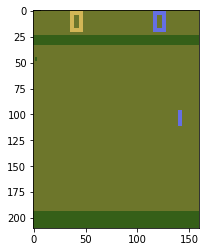

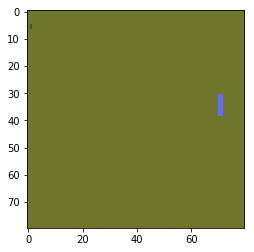

In [3]:
# (210, 160) 게임 화면 출력
plt.imshow(env.reset())
plt.show()
# (80, 80) 자른 게임 화면 출력
plt.imshow(env.reset()[35:195:2, ::2])
plt.show()

In [4]:
# 입력 게임 화면을 전처리하기 위해 preprocess_observation 함수 정의
# 이미지 크기를 줄이고 이미지를 grey-scale로 변환
color = np.array([210,164,74]).mean()

def preprocess_observation(obs):
    #이미지 자르기 및 크기 조정
    img = obs[35:195:2, ::2]
    #이미지를 grey-scale로 변환
    img = img.mean(axis=2)
    #이미지 대비 향상
    img[img==color] = 0
    #다음으로 이미지를 -1에서 1로 정규화
    img = (img - 128) / 128 - 1
    
    return img.reshape(80,80,1)

In [5]:
# Q network를 구축하기 위해 q_network라는 함수를 정의
# Q network를 입력하고 해당 state의 모든 action에 대한 Q 값을 얻는다.
# fully connected layer가 이어지는 동일한 패딩을 가진 3개의 convolutional layers로 Q 네트워크를 구축
tf.reset_default_graph()

def q_network(X, name_scope):
    #layers 초기화
    initializer = tf.contrib.layers.variance_scaling_initializer()
    
    with tf.variable_scope(name_scope) as scope:
        #convolutional layers 초기화
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding="SAME", weights_initializer=initializer)
        tf.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding="SAME", weights_initializer=initializer)
        tf.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding="SAME", weights_initializer=initializer)
        tf.summary.histogram('layer_3',layer_3)
        
        # fully connected layer에 공급하기 전에 layer_3의 결과를 평탄화
        flat = flatten(layer_3)
        
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.summary.histogram('fc',fc)
        
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.summary.histogram('output',output)
        
        #vars는 가중치와 같은 네트워크 매개변수를 저장
        vars = {v.name[len(scope.name):]: v for v in tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
        return vars, output

In [6]:
# 엡실론 그리디 정책을 수행하기 위해 epsilon_greedy라는 함수를 정의
# 영원히 탐색하고 싶지 않기 때문에 엡실론의 가치가 시간이 지남에 따라 쇠퇴하는 decaying epsilon greedy 정책을 사용
# 즉, 시간이 지남에 따라 우리 정책은 좋은 행동만 이용할 것입니다.
eps_min=0.05
eps_max=0.8
eps_decay_steps = 500000

def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze()
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [7]:
# 경험을 보유하는 50000의 경험 버퍼를 초기화
# 에이전트의 모든 경험, 즉 (상태, 행동, 보상)을 replay buffer에 저장하고 네트워크 훈련을 위해 이 경험의 미니배치에서 샘플링
buffer_len = 20000
exp_buffer = deque(maxlen=buffer_len)

# 메모리에서 경험을 샘플링하기 위해 sampled_memories라는 함수를 정의
# 배치 크기는 메모리에서 샘플링된 경험의 수이다.
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0],mem[:,1],mem[:,2],mem[:,3],mem[:,4]

In [8]:
# hyperparameter 정의
num_episodes = 500
batch_size = 48
input_shape = (None, 80, 80, 1)
learning_rate = 0.001
X_shape = (None, 80, 80, 1)
discount_factor = 0.99

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 1000

In [9]:
logdir = 'pong_logs'
tf.reset_default_graph()

# 입력에 대한 게임 상태를 정의
X = tf.placeholder(tf.float32, shape=X_shape)

# 학습을 껐다 켰다하기 위해 in_training_model이라는 부울을 정의
in_training_mode = tf.placeholder(tf.bool)

In [10]:
# 기본 대상 Q network를 구축
# 입력 X를 취하고 state의 모든 action에 대해 Q 값을 생성하는 Q network를 구축
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# 목표 Q network를 구축
targetQ, targetQ_outputs = q_network(X, 'targetQ')

In [11]:
# action values에 대한 placeholder 정의
X_action = tf.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1,keep_dims=True)

In [12]:
# 기본 Q 네트워크 매개변수를 대상 Q 네트워크에 복사
copy_op = [tf.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [13]:
# gradient descent optimizer를 사용하여 손실 계산 및 최적화

# action에 대한 placeholder를 정의
y = tf.placeholder(tf.float32, shape=(None,1))

# 실제 값과 예측 값의 차이인 손실을 계산
loss = tf.reduce_mean(tf.square(y - Q_action))

# loss을 최소화하기 위해 adam optimizer를 사용
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

loss_summary = tf.summary.scalar('Loss', loss)
merge_summary = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

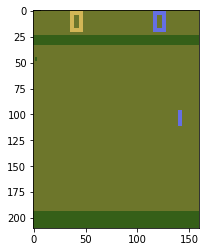

Epoch 3082 Reward -13.0


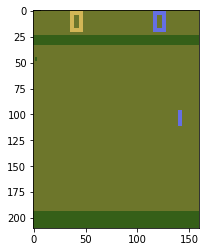

In [14]:
# tensorflow와 그 안의 모델을 실행
with tf.Session() as sess:
    init.run()
    
    # 로그를 기록할 파일 열기
    log_file = "pong_log.txt"
    
    #에피소드
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter()
        episodic_loss = []
        
        plt.imshow(env.render(mode='rgb_array'))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        #상태가 최종 상태가 아닌 동안
        while not done:
            # 전처리된 게임 화면 가져오기
            obs = preprocess_observation(obs)
            
            # 게임 화면을 피드하고 각 작업에 대한 Q 값을 가져오기
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode: False})
            
            # 행동 가져오기
            action = np.argmax(actions, axis =-1)
            actions_counter[str(action)] += 1
            
            #엡실론 그리디 정책을 사용하여 행동 선택
            action = epsilon_greedy(action, global_step)
            
            #행동을 수행하고 다음 상태인 next_obs로 이동하여 보상을 받는다.
            next_obs, reward, done, _ = env.step(action)
            
            #이 전환을 재생 버퍼에 경험으로 저장
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            #특정 단계 후에 경험 버퍼의 샘플로 Q 네트워크를 훈련
            if global_step % steps_train == 0 and global_step > start_steps:
                # 샘플 경험
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)
                
                # 상태
                o_obs = [x for x in o_obs]
                
                # 다음 상태
                o_next_obs = [x for x in o_next_obs]
                
                # 다음 행동
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})
                
                # 보상
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done)
                
                # 모든 요약을 병합하고 파일에 쓰기
                mrg_summary = merge_summary.eval(feed_dict={X: o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)
                
                # 네트워크 훈련 및 loss 계산
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode: True})
                episodic_loss.append(train_loss)
                
            # 일정 간격 후에 주요 Q 네트워크 가중치를 대상 Q 네트워크에 복사
            if (global_step+1)%copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                    
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
            
            # 일정 간격마다 게임 화면 실시간 시각화 (속도 저하를 방지하기 위해 주석처리)
            #if epoch % 10 == 0:
            #    plt.imshow(env.render(mode='rgb_array'))
            #    display.clear_output(wait=True)
            #    display.display(plt.gcf())
            
        # 파일에 로그 기록
        with open(log_file, "a") as file:
            file.write("Epoch: " + str(epoch) + ", Reward: " + str(episodic_reward))
            file.write(", Loss: " + str(np.mean(episodic_loss)))
            file.write(", Actions: " + str(actions_counter) + "\n")
        
        # 정보 출력
        print('Epoch', epoch, 'Reward', episodic_reward)
        
    # 저장 객체 생성
    saver = tf.train.Saver()
    
    # 모델 저장
    saver.save(sess, './pong_model', global_step=global_step)

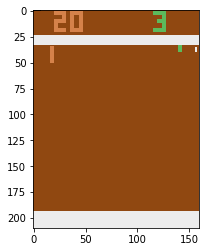

Episode Reward=  -18.0


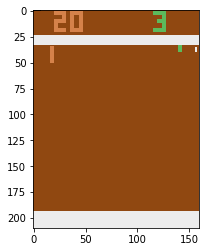

In [14]:
# 학습한 모델을 불러와 게임 진행
with tf.Session() as sess:
    # 저장 객체 생성
    saver = tf.train.Saver()
    
    # 저장된 모델 로드
    saver.restore(sess, './pong_model-831551') 

    done = False
    obs = env.reset()
    total_reward = 0

    #상태가 최종 상태가 아닌 동안
    while not done:

        plt.imshow(env.render(mode='rgb_array'))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        obs = preprocess_observation(obs)
            
        # 게임 화면을 피드하고 각 작업에 대한 Q 값을 가져오기
        actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode: False})

        # 행동 가져오기
        action = np.argmax(actions, axis =-1)

        #행동을 수행하고 다음 상태인 next_obs로 이동하여 보상을 받는다.
        next_obs, reward, done, _ = env.step(action)
        total_reward += reward
        obs = next_obs
        print("Episode Reward= ", total_reward)
